> 提示：项目 Notebook 模板主要为了帮助同学了解如何划分报告结构，提示项目的注意事项。如果你理解项目的所有要求，那么完全可以自己创建新的 Notebook 来完成报告。

> 提交项目时，建议删除所有提示性文字，只保留你自己的 Markdown 说明文字和代码注释。

# 清理与分析数据（替换为你自己的报告标题）
## 收集

In [1]:
# 导入需要的库
import numpy as np
import pandas as pd
import json
import requests
import re

> 提示：你需要收集的文件有：
1. 收集手头文件 `twitter_archive_enhanced.csv`，其中包含了一些主要的推特信息，是本次清洗的主要数据，其中的评分、地位和名字等数据是从 `text` 原文中提取的，但是提取的并不好，评分并不都是正确的，狗的名字和地位也有不正确的 。**如果你想用评分、地位和名字进行分析和可视化，需要评估和清洗这些列。完成这些列的评估和清洗，你可以学到更加实用的技能。**
2. 编程下载收集互联网文件：`image-predictions.tsv`，其中包含了推特图像预测信息，根据推特中的图片预测出狗狗种类；
3. 查询 API 收集额外推特信息 `tweet_json.txt`，如果你无法访问 Twitter 的话，可以直接读取项目可供下载的 `tweet_json.txt` 文件，从中提取所需数据。至少需要提取转发数（`retweet_count`）和喜欢数（`favorite_count`）这两列，**如果你的分析中不需要用到其他列，则不需要收集其他列**。如果提取了其他列只用于清洗，那么这样的清洗没有意义。

In [2]:
# 收集文件 1 保存为 twitter
twitter = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
# 收集文件 2 保存为 image
url = 'https://raw.githubusercontent.com/udacity/new-dand-advanced-china/master/%E6%95%B0%E6%8D%AE%E6%B8%85%E6%B4%97/WeRateDogs%E9%A1%B9%E7%9B%AE/image-predictions.tsv'

response = requests.get(url)
response

<Response [200]>

In [4]:
with open(url.split('/')[-1],mode = 'wb') as file:
    file.write(response.content)
    
image = pd.read_csv('image-predictions.tsv',sep = '\t')

In [5]:
# 收集文件 3 保存为 tweet
df_list = []

with open('tweet_json.txt') as f:
    tweet_json = f.readlines()
    for line in tweet_json:
        tweet_id = json.loads(line)['id']
        retweet_count = json.loads(line)['retweet_count']
        favorite_count = json.loads(line)['favorite_count']
        
        df_list.append({'tweet_id':tweet_id,
                        'retweet_count':retweet_count,
                        'favorite_count':favorite_count})
tweet = pd.DataFrame(df_list,columns=['tweet_id','retweet_count','favorite_count'])

## 评估
### 目测评估

In [6]:
# 目测评估三个数据集

In [7]:
twitter.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


##### 该数据集中，in_reply_to_status_id、in_reply_to_user_id、retweeted_status_id、retweeted_status_user_id、retweeted_status_timestamp存在较多的空值可以进一步查看详细数据，timestamp日期格式混乱，source可以进一步提取

In [8]:
image.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


##### 这组数据可以将预测的可信度调整为保留到小数点后两位

In [9]:

tweet.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8842,39492
1,892177421306343426,6480,33786
2,891815181378084864,4301,25445
3,891689557279858688,8925,42863
4,891327558926688256,9721,41016


### 编程评估

In [10]:
# 使用 pandas 的各种方法评估三个数据集，比如 info value_counts 等

In [11]:
twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

- tweet_id 应该为字符串类型，而不是int64 数值类型，所以需要修改。后面三个表同样发现都需要统一成字符串类型  
- in_reply_to_status_id、in_reply_to_user_id只有78条数据，且大部分为空值，可以直接删除

In [12]:
twitter.name.value_counts()

None         745
a             55
Charlie       12
Oliver        11
Lucy          11
Cooper        11
Penny         10
Tucker        10
Lola          10
Winston        9
Bo             9
Sadie          8
the            8
Toby           7
Daisy          7
Bailey         7
an             7
Buddy          7
Leo            6
Koda           6
Dave           6
Oscar          6
Bella          6
Stanley        6
Milo           6
Scout          6
Rusty          6
Jax            6
Jack           6
Sunny          5
            ... 
Champ          1
Bluebert       1
Skittles       1
Nugget         1
Steve          1
Mutt           1
Tess           1
such           1
Willie         1
Ambrose        1
Tommy          1
Sprinkles      1
Bruno          1
Horace         1
Finnegus       1
Tessa          1
Randall        1
Fiji           1
Peanut         1
Pip            1
Carll          1
Norman         1
Caryl          1
Colin          1
Ebby           1
Jomathan       1
Boots          1
Rose          

##### 狗狗的姓名提取存在异常，有些是None，有的为a

In [13]:
twitter.retweeted_status_user_id.notnull().value_counts()

False    2175
True      181
Name: retweeted_status_user_id, dtype: int64

##### retweeted_status_user_id 不为空的说明是转发的推文 ，需要清理，只留下非转发的推文

In [14]:
image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [15]:
sum(image.jpg_url.duplicated())

66

##### image表中，图片链接有重复项，可能是收集导致的错误，需要删除

In [16]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2352 entries, 0 to 2351
Data columns (total 3 columns):
tweet_id          2352 non-null int64
retweet_count     2352 non-null int64
favorite_count    2352 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


> 提示：
- 完成目测评估和编程评估之后，总结列出你发现的三个数据集中的所有问题；
- 每个问题都要有对应的一句话或几句话描述；
- 最终至少要包含 8 个质量问题和 2 个整洁度问题。

#### 质量
##### ` twitter` 表格
- 把tweet_id改为字符串类型而不是数值类型，后面两个表也进行同样的处理
- 狗狗评分需要在text中重新提取
- 狗狗分类需要在text中重新提取
- 调整timestamp格式
- source列报含多余的HTML信息，可以进一步提取
- 删除expanded_urls列的空值
- in_reply_to_status_id、in_reply_to_user_id只有78条数据，且大部分为空值，删除即可
- retweeted_status_user_id 不为空的说明是转发的推文 ，需要清理，只留下非转发的推文
##### `image` 表格
- 删除jpg_url列重复数据
#### 整洁度
- 狗狗的地位(stage)应该为分类变量，在一列中体现
- 三个表都有tweet_id，可以进一步整合为一个表
## 清理

> 提示：
- 清理数据集之前需要先备份数据集；
- 按照下面示例的结构：**定义-代码-测试**，对提出的每个问题进行清洗。

In [17]:
# 备份三个数据集
twitter_clean = twitter.copy()
image_clean = image.copy()
tweet_clean = tweet.copy()

###### 问题描述一
##### 把tweet_id改为字符串类型而不是数值类型，后面两个表也进行同样的处理

In [18]:
# 定义：使用astype方法把三个表中的tweet_id该为字符串类型
# 代码
twitter_clean['tweet_id'] = twitter_clean['tweet_id'].astype('str')
image_clean['tweet_id'] = image_clean['tweet_id'].astype('str')
tweet_clean['tweet_id'] = tweet_clean['tweet_id'].astype('str')

In [19]:
# 测试
image_clean.dtypes

tweet_id     object
jpg_url      object
img_num       int64
p1           object
p1_conf     float64
p1_dog         bool
p2           object
p2_conf     float64
p2_dog         bool
p3           object
p3_conf     float64
p3_dog         bool
dtype: object

###### 问题描述二
##### 狗狗评分需要在text中重新提取

In [20]:
# 定义：使用正则表达式和split方法提取狗狗评分
# 代码
twitter_clean['rating'] = twitter_clean['text'].str.extract(r'(\d+\.?\d*\/\d+)',expand = False)
twitter_clean['rating_numerator'] = twitter_clean.rating.apply(lambda x : x.split('/')[0])
twitter_clean['rating_denominator'] = twitter_clean.rating.apply(lambda x : x.split('/')[1])
twitter_clean['rating_denominator'] = twitter_clean['rating_denominator'].astype('int')
twitter_clean = twitter_clean[twitter_clean['rating_denominator'] == 10]

In [21]:
# 测试
twitter_clean['rating_denominator'].value_counts()

10    2333
Name: rating_denominator, dtype: int64

###### 问题描述三
##### 质量：狗狗分类需要在text中重新提取
##### 整洁性：狗狗的地位(stage)应该为分类变量，在一列中体现

In [22]:
# 定义:1）狗狗的地位有些不准确，有些是缺失的，使用find方法重新提取  
#      2）同时处理整洁问题：将狗狗地位(stage)在一列中体现
# 代码
twitter_clean['stage'] = twitter_clean.text.str.lower().str.findall(r'(doggo|pupper|puppo|floof)')
twitter_clean['stage'] = twitter_clean.stage.apply(lambda x:','.join(set(x)))
twitter_clean['stage'] = twitter_clean['stage'].replace('',np.nan)

In [23]:
# 测试
twitter_clean['stage'].value_counts()

pupper          263
doggo            89
puppo            36
floof            36
doggo,pupper     12
doggo,floof       3
doggo,puppo       2
pupper,floof      1
Name: stage, dtype: int64

In [24]:
# 删除多余的分类
twitter_clean.drop(twitter_clean[['doggo','pupper','puppo','floofer']],axis=1,inplace=True)

##### 问题描述四
##### 统一调整timestamp的格式

In [25]:
# 定义：使用datetime调整timestamp格式
# 代码
twitter_clean['timestamp'] = pd.to_datetime(twitter_clean['timestamp'],format='%Y-%m')

In [26]:
# 测试
twitter_clean['timestamp']

0      2017-08-01 16:23:56
1      2017-08-01 00:17:27
2      2017-07-31 00:18:03
3      2017-07-30 15:58:51
4      2017-07-29 16:00:24
5      2017-07-29 00:08:17
6      2017-07-28 16:27:12
7      2017-07-28 00:22:40
8      2017-07-27 16:25:51
9      2017-07-26 15:59:51
10     2017-07-26 00:31:25
11     2017-07-25 16:11:53
12     2017-07-25 01:55:32
13     2017-07-25 00:10:02
14     2017-07-24 17:02:04
15     2017-07-24 00:19:32
16     2017-07-23 00:22:39
17     2017-07-22 16:56:37
18     2017-07-22 00:23:06
19     2017-07-21 01:02:36
20     2017-07-20 16:49:33
21     2017-07-19 16:06:48
22     2017-07-19 03:39:09
23     2017-07-19 00:47:34
24     2017-07-18 16:08:03
25     2017-07-18 00:07:08
26     2017-07-17 16:17:36
27     2017-07-16 23:58:41
28     2017-07-16 20:14:00
29     2017-07-15 23:25:31
               ...        
2325   2015-11-17 00:53:15
2326   2015-11-17 00:24:19
2327   2015-11-17 00:06:54
2328   2015-11-16 23:23:41
2329   2015-11-16 21:54:18
2330   2015-11-16 21:10:36
2

##### 问题描述五
##### source列报含多余的HTML信息，可以进一步提取

In [27]:
# 定义：使用正则表达式提取Html内容
# 代码
twitter_clean['source'] = twitter_clean['source'].str.extract('>(.+)<',expand = True)

In [28]:
# 测试
twitter_clean['source'].value_counts()

Twitter for iPhone     2198
Vine - Make a Scene      91
Twitter Web Client       33
TweetDeck                11
Name: source, dtype: int64

##### 问题描述六
- 删除expanded_urls列的空值
- in_reply_to_status_id、in_reply_to_user_id只有78条数据，且大部分为空值，删除即可
- retweeted_status_user_id 不为空的说明是转发的推文 ，需要清理，只留下非转发的推文
- 删除jpg_url列重复数据

In [29]:
# 代码
twitter_clean = twitter_clean[twitter_clean['expanded_urls'].notnull()]
twitter_clean.drop(twitter_clean[['in_reply_to_status_id','in_reply_to_user_id']],axis=1,inplace = True )
twitter_clean = twitter_clean[twitter_clean['retweeted_status_user_id'].isnull()]

In [30]:
# 测试
twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2099 entries, 0 to 2355
Data columns (total 13 columns):
tweet_id                      2099 non-null object
timestamp                     2099 non-null datetime64[ns]
source                        2099 non-null object
text                          2099 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2099 non-null object
rating_numerator              2099 non-null object
rating_denominator            2099 non-null int64
name                          2099 non-null object
rating                        2099 non-null object
stage                         395 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(9)
memory usage: 229.6+ KB


In [31]:
# 删除相关列
twitter_clean.drop(twitter_clean[['retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp']],axis=1,inplace = True )

In [32]:
# 代码
image_clean.drop_duplicates('jpg_url',inplace=True)

In [33]:
# 测试
sum(image_clean.jpg_url.duplicated())

0

### 存储清理后的主数据集

In [34]:
# 将清理后的主数据集保存为 csv 文件或者 SQLite 数据库文件
df_clean = twitter_clean.merge(image_clean,on = 'tweet_id').merge(tweet_clean,how = 'left',on = 'tweet_id')

In [35]:
df_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,rating,stage,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,13/10,NaN,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,8842,39492
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,13/10,NaN,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,6480,33786
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,12/10,NaN,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,4301,25445
3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,13/10,NaN,...,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,8925,42863
4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,12/10,NaN,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,9721,41016


In [36]:
# 把图片预测结果不属于狗的数据删掉
df_clean = df_clean[(df_clean['p1_dog']==True)|(df_clean['p2_dog']==True)|(df_clean['p3_dog']==True)]

In [37]:
# 查看数据集信息
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1669 entries, 1 to 1975
Data columns (total 23 columns):
tweet_id              1669 non-null object
timestamp             1669 non-null datetime64[ns]
source                1669 non-null object
text                  1669 non-null object
expanded_urls         1669 non-null object
rating_numerator      1669 non-null object
rating_denominator    1669 non-null int64
name                  1669 non-null object
rating                1669 non-null object
stage                 306 non-null object
jpg_url               1669 non-null object
img_num               1669 non-null int64
p1                    1669 non-null object
p1_conf               1669 non-null float64
p1_dog                1669 non-null bool
p2                    1669 non-null object
p2_conf               1669 non-null float64
p2_dog                1669 non-null bool
p3                    1669 non-null object
p3_conf               1669 non-null float64
p3_dog                1669 no

In [38]:
df_clean.to_csv('twitter_archive_master.csv',index = False)

## 分析和可视化

> 提示：
- 在 Notebook 使用 pandas 或 SQL 分析主数据集，并生成至少三（3）个独立的结论。
- 在 Notebook 中使用 Python 绘图库或在 Tableau 中至少生成一（1）个可视化图表。


In [39]:
# 导如可视化库
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#### 一、我们来看一下各个排名榜首的小明星

In [40]:
# 点赞数最多的狗狗
df_clean.sort_values(by='favorite_count',ascending=False).head(1)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,rating,stage,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
309,822872901745569793,2017-01-21 18:26:02,Twitter for iPhone,Here's a super supportive puppo participating ...,https://twitter.com/dog_rates/status/822872901...,13,10,None,13/10,puppo,...,0.196015,True,Labrador_retriever,0.160329,True,Irish_terrier,0.069126,True,47958,132318


![](https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg)

##### 这小家伙儿可是点赞数最多的小奶狗

In [41]:
# 转发数最多的狗狗
df_clean.sort_values(by='retweet_count',ascending=False).head(1)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,rating,stage,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
772,744234799360020481,2016-06-18 18:26:18,Twitter for iPhone,Here's a doggo realizing you can stand in a po...,https://twitter.com/dog_rates/status/744234799...,13,10,None,13/10,doggo,...,0.825333,True,ice_bear,0.044681,False,whippet,0.018442,True,79116,130533


![](https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg)

#### 转发数最多的游泳健将
#### 二、观察转发数与狗狗评分之间的关系

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


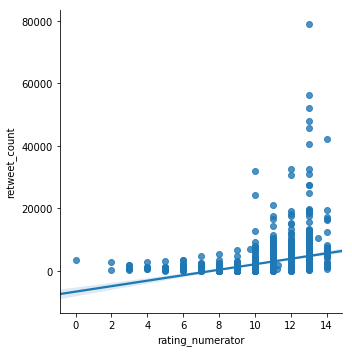

In [42]:
df_retweet = df_clean[['rating_numerator','retweet_count']]
df_retweet['rating_numerator'] = df_retweet['rating_numerator'].astype('float')
sns.lmplot(x='rating_numerator', y='retweet_count',data = df_retweet);

#### 通过上面的回归图可以看出，转发数与狗狗评分呈正相关，说明大家对评分高的狗狗还是有些偏爱
#### 三、转发数最多的时那种类型的狗狗呢

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


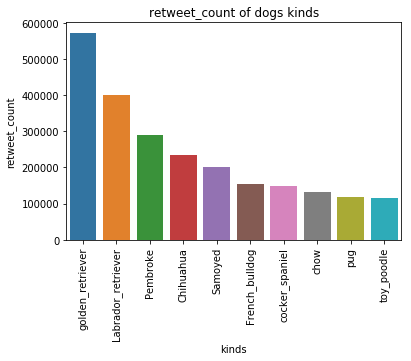

In [43]:
df_kind = df_clean[['p1','p1_dog','p2','p2_dog','p3','p3_dog','retweet_count']]

#设置一个list接受值
kinds=[]
for i in df_kind.index:
    if df_kind.p1_dog.loc[i]==True:
        kinds.append(df_kind.p1.loc[i])
    elif df_kind.p2_dog.loc[i]==True:
        kinds.append(df_kind.p2.loc[i])
    elif df_kind.p3_dog.loc[i]==True:
        kinds.append(df_kind.p3.loc[i])
    else:
        kinds.append(np.nan)
        
df_kind['kinds']=kinds
#删除空值
df_kind = df_kind[df_kind.kinds.notnull()]

#按喜爱排序统计各品种数量，取前10行数据
datas = df_kind.groupby('kinds')['retweet_count'].sum().sort_values(ascending=False).head(10)
#还原索引
datas = datas.reset_index()

sns.barplot(x=datas.kinds,y=datas['retweet_count'])
plt.title('retweet_count of dogs kinds')
plt.xticks(rotation=90)
plt.show()

#### 从上图中可以看到，金毛是很受欢迎的犬种，我相信这与它友善的性格、可爱的外表和超高的智商是有很大关系的
#### 四、观察下推特发展的情况（点赞数）

In [44]:
df_date = df_clean[['timestamp','favorite_count']]
df_date = df_clean.groupby('timestamp')['favorite_count'].sum()
df_date = df_date.reset_index()

In [45]:
df_date['timestamp'] = df_date['timestamp'].map(lambda x: 100*x.year + x.month)

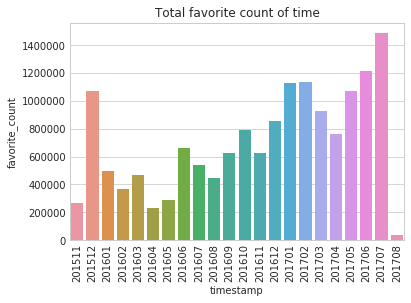

In [46]:
sns.set_style('whitegrid')
sns.barplot(x='timestamp',y='favorite_count',estimator = sum,data = df_date,ci=0)
plt.title('Total favorite count of time')
plt.xticks(rotation=90)
plt.show()

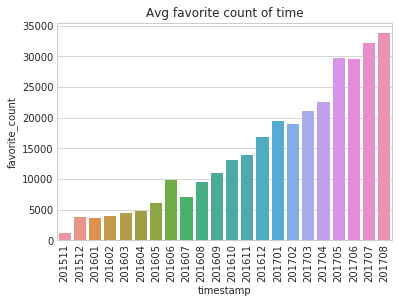

In [47]:
sns.set_style('whitegrid')
sns.barplot(x='timestamp',y='favorite_count',data = df_date,ci=0)
plt.title('Avg favorite count of time')
plt.xticks(rotation=90)
plt.show()

#### 这两张图都是以点赞数作为分析的切入点，但是是从两个不同维度的取刨析分析，因而也得到了很有意义的结论
- 从第一张图来看，推文的点赞数在15年的12月呈爆发式增长，通过上网收集资料得知，那时是博主创业之初，伴随着超高的激情，16年春季推特账号的点赞量有些下滑，结合媒体的报道，当时账号正在经受初期的失败和团队动荡，之后便进入好转，虽说点赞数一直有起有伏，但总体还是呈上升趋势的
- 第二张图是时从平均点赞数来观察数据，我们可以看到即使推文的点赞数跌宕起伏，但是推文质量(平均点赞量)在稳步提升，这就非常的厉害了

> 提示：在完成 Notebook 的所有内容之后，还需要完成两篇文本和图片组成的 PDF 报告。因为这两篇报告中只是文字和图片，不需要包含代码，你可以使用文字编辑软件，比如 Word 来完成：
- 创建一个 300-600 字的书面报告，命名为 `wrangle_report.pdf`，在该报告中简要描述你的数据整理过程。这份报告可以看作是一份内部文档，供你的团队成员查看交流。
- 创建一个 250 字以上的书面报告，命名为 `act_report.pdf`，在该报告中，你可以与读者交流观点，展示你使用整理过的数据生成的可视化图表。这份报告可以看作是一份外部文档，如博客帖子或杂志文章。

> 提示：提交项目前建议删除 Notebook 中的所有提示性文字和注释，只保留自己的 Markdown 文本和代码注释。